# Titanic: Machine Learning from Disaster

This dataset is from [kaggle](https://www.kaggle.com/c/titanic/data)

## Overview 

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.  
  
  

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.  
  
  

In this notebook, I try to complete the analysis of what sorts of people were likely to survive. In particular, I try to predict which passengers survived the tragedy.

## Dataset

The data has been split into two groups:  
  
  
-training set (train.csv)  
-test set (test.csv)  

***Variable Notes***  
pclass: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  
  
    
**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5  


**sibsp**: The dataset defines family relations in this way...  
Sibling = brother, sister, stepbrother, stepsister  
Spouse = husband, wife (mistresses and fiancés were ignored)  

**parch**: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  


## Step 1 

This kernel is highly based on Anisotropic's Introduction to Ensembling/Stacking in Python.   
I only test my Feature Engineering here.

In [9]:
# import the packages
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;

# Input data files are available in the "/input/" directory.

In [7]:
data = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
PassengerId = test['PassengerId']

In [10]:
data['Age'].fillna(data['Age'].median(),inplace = True)
test['Age'].fillna(test['Age'].median(),inplace = True)
data['FamilySize'] = data['Parch'] + data['SibSp']
test['FamilySize'] = test['Parch'] + test['SibSp']
data['Embarked'].fillna('S',inplace = True)
test['Embarked'].fillna('S',inplace = True)
data['Fare'].fillna(data['Fare'].median(),inplace = True)
test['Fare'].fillna(test['Fare'].median(),inplace = True)

maxFare = data['Fare'].max()
maxFare = test['Fare'].max()

def is_rich(fare):
    if(fare <= maxFare/3):
        return 1
    elif(fare <= (maxFare/3)*2):
        return 2
    else:
        return 3
    
data['Rich']=data['Fare'].map(lambda x: is_rich(x))
test['Rich']=test['Fare'].map(lambda x: is_rich(x))
data['VRich'] = data['Rich'] * data['Pclass']
test['VRich'] = test['Rich'] * test['Pclass']
data['Sex'] = data['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [11]:
drop_cols = ['PassengerId','Name','Ticket','Cabin','SibSp','Parch','Embarked']

data = data.drop(drop_cols, axis = 1)
test = test.drop(drop_cols, axis = 1)

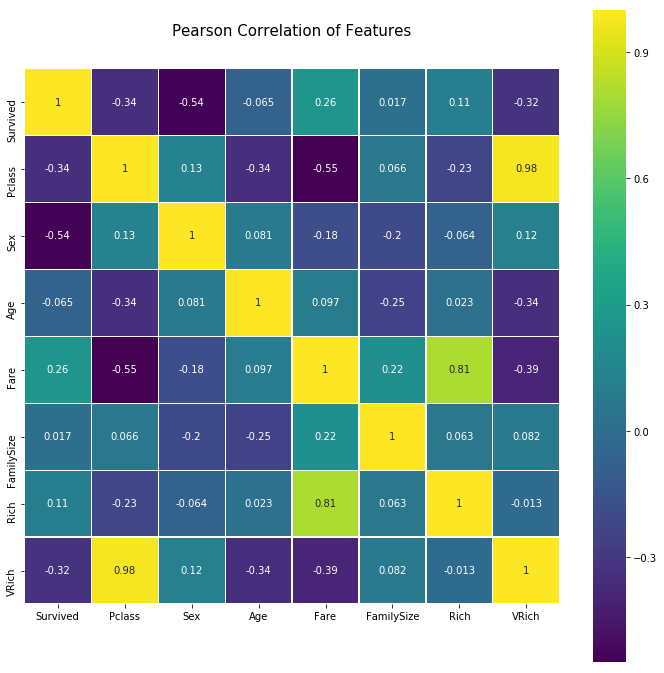

In [12]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
ntrain = data.shape[0]
ntest = test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain,n_folds = NFOLDS,random_state = SEED)
class SklearnHelper(object):
    def __init__(self, clf, seed = 0, params = None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self, x, y):
        return self.clf.fit(x, y)
    
    def feature_importances(self, x, y):
        print(self.clf.fit(x,y).feature_importances_)
        
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    
    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
    
        clf.train(x_tr,y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis = 0)
    return oof_train.reshape(-1,1), oof_test.reshape(-1,1)

In [14]:
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [15]:
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [16]:
y_train = data['Survived'].ravel()
data = data.drop(['Survived'], axis=1)
x_train = data.values # Creates an array of the training data
x_test = test.values # Creats an array of the testing data

In [17]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

C:\Users\admin\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\ensemble\forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is complete


In [20]:
rf_features = rf.feature_importances(x_train,y_train)
et_features = et.feature_importances(x_train, y_train)
ada_features = ada.feature_importances(x_train, y_train)
gb_features = gb.feature_importances(x_train,y_train)

C:\Users\admin\Anaconda3\envs\tensorflow-gpu\lib\site-packages\sklearn\ensemble\forest.py:304: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


[ 0.11252024  0.37851422  0.13357929  0.20574792  0.08023473  0.00477513
  0.08462847]
[ 0.11936913  0.55853693  0.06787114  0.0704249   0.06673949  0.00843644
  0.10862196]
[ 0.012  0.018  0.238  0.698  0.032  0.002  0.   ]
[ 0.02242833  0.04827376  0.36937346  0.49180125  0.04932938  0.00108707
  0.01770675]


In [21]:
cols = data.columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [22]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [23]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [24]:
gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [25]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)